# Lab №2

## Выполнение  Robot Kinematics and Trajectory Planning

### 0. Импортируем необходимые библиотеки 

In [21]:
# 0. Import necessary libraries
from math import pi
import numpy as np
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
import spatialmath.base as sb
from roboticstoolbox import trapezoidal, quintic
from spatialmath import SE3
from mpl_toolkits.mplot3d import Axes3D

### 1. Импортируем модель Puma560

In [23]:
# 1. Load and configure the Puma560 robot model
robot = rtb.models.DH.Puma560()
print(robot)

# 2. Set dynamic parameters (from Lab 1)
# Masses
robot.links[0].m = 20
robot.links[1].m = 17.4
robot.links[2].m = 4.8
robot.links[3].m = 0.82
robot.links[4].m = 0.34
robot.links[5].m = 0.09

# Centers of mass
robot.links[0].r = [0, 0, 0]
robot.links[1].r = [-0.3638, 0.006, 0.2275]
robot.links[2].r = [-0.0203, -0.0141, 0.07]
robot.links[3].r = [0, 0.019, 0]
robot.links[4].r = [0, 0, 0]
robot.links[5].r = [0, 0, 0.032]

# Inertia tensors
robot.links[0].I = [0, 0.35, 0, 0, 0, 0]
robot.links[1].I = [0.13, 0.524, 0.539, 0, 0, 0]
robot.links[2].I = [0.066, 0.086, 0.0125, 0, 0, 0]
robot.links[3].I = [0.0018, 0.0013, 0.0018, 0, 0, 0]
robot.links[4].I = [0.0003, 0.0004, 0.0003, 0, 0, 0]
robot.links[5].I = [0.00015, 0.00015, 0.00004, 0, 0, 0]

# Motor inertias
robot.links[0].Jm = 0.0004
robot.links[1].Jm = 0.0004
robot.links[2].Jm = 0.0004
robot.links[3].Jm = 0.000033
robot.links[4].Jm = 0.000033
robot.links[5].Jm = 0.000033

# Viscous friction coefficients
robot.links[0].B = 0.0015
robot.links[1].B = 0.000817
robot.links[2].B = 0.00138
robot.links[3].B = 0.0000712
robot.links[4].B = 0.0000826
robot.links[5].B = 0.0000367

# Coulomb friction coefficients
robot.links[0].Tc = [0.395, -0.435]
robot.links[1].Tc = [0.126, -0.071]
robot.links[2].Tc = [0.132, -0.105]
robot.links[3].Tc = [0.0112, -0.0169]
robot.links[4].Tc = [0.00926, -0.0145]
robot.links[5].Tc = [0.00396, -0.0105]

# Gear ratios
robot.links[0].G = -62.6111
robot.links[1].G = 107.8150000000000
robot.links[2].G = -53.7063
robot.links[3].G = 76.0364
robot.links[4].G = 71.923
robot.links[5].G = 76.686

# Joint limits
robot.links[0].qlim = [-2.792526803190927, 2.792526803190927]
robot.links[1].qlim = [-0.785398163397448, 3.926990816987241]
robot.links[2].qlim = [-3.926990816987241, 0.785398163397448]
robot.links[3].qlim = [-1.919862177193763, 2.967059728390360]
robot.links[4].qlim = [-1.745329251994330, 1.745329251994330]
robot.links[5].qlim = [-4.642575810304916, 4.642575810304916]

print("Robot model parameters set as in Lab 1")
print(robot)

DHRobot: Puma 560 (by Unimation), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌─────┬────────┬────────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ   │   ⍺ⱼ   │   q⁻    │   q⁺   │
├─────┼────────┼────────┼────────┼─────────┼────────┤
│  q1 │ 0.6718 │      0 │  90.0° │ -160.0° │ 160.0° │
│  q2 │      0 │ 0.4318 │   0.0° │ -110.0° │ 110.0° │
│  q3 │   0.15 │ 0.0203 │ -90.0° │ -135.0° │ 135.0° │
│  q4 │ 0.4318 │      0 │  90.0° │ -266.0° │ 266.0° │
│  q5 │      0 │      0 │ -90.0° │ -100.0° │ 100.0° │
│  q6 │      0 │      0 │   0.0° │ -266.0° │ 266.0° │
└─────┴────────┴────────┴────────┴─────────┴────────┘

┌──┬──┐
└──┴──┘

┌──────┬─────┬──────┬───────┬─────┬──────┬─────┐
│ name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├──────┼─────┼──────┼───────┼─────┼──────┼─────┤
│   qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│   qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│   qn │  0° │  45° │  180° │  0° │  45° │  0° │
│   qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
└──

### 2. Зададим начальное положение робота и построим его


Initial configuration:
q1: 0.785 rad, q2: -1.047 rad, q3: -0.785 rad
q4: 1.047 rad, q5: -1.047 rad, q6: 0.785 rad


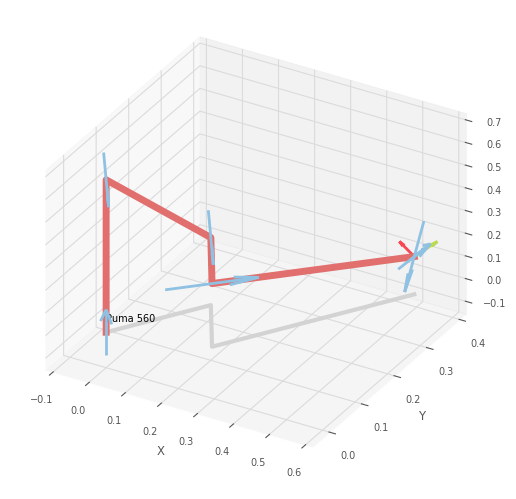

<Figure size 640x480 with 0 Axes>

In [45]:
# 2. Set initial configuration
q_start = [pi/4, -pi/3, -pi/4, pi/3, -pi/3, pi/4]
print("\nInitial configuration:")
print(f"q1: {q_start[0]:.3f} rad, q2: {q_start[1]:.3f} rad, q3: {q_start[2]:.3f} rad")
print(f"q4: {q_start[3]:.3f} rad, q5: {q_start[4]:.3f} rad, q6: {q_start[5]:.3f} rad")

robot.plot(q_start, block=False)
plt.show()

### 3. Решим прямую задачу кинематики

In [46]:
# 3. Solve forward kinematics for initial configuration
T_start = robot.fkine(q_start)
print("\nForward kinematics solution (T_start):")
print(T_start)



Forward kinematics solution (T_start):
  -0.805     0.5292   -0.2681    0.55      
   0.128     0.5962    0.7926    0.3378    
   0.5792    0.6038   -0.5477    0.1665    
   0         0         0         1         



### 6. Построим рабочую зону манипулятора

Инициализируем переменные

Рассчитываем рабочую зону

Строим рабочую зону


Building workspace...


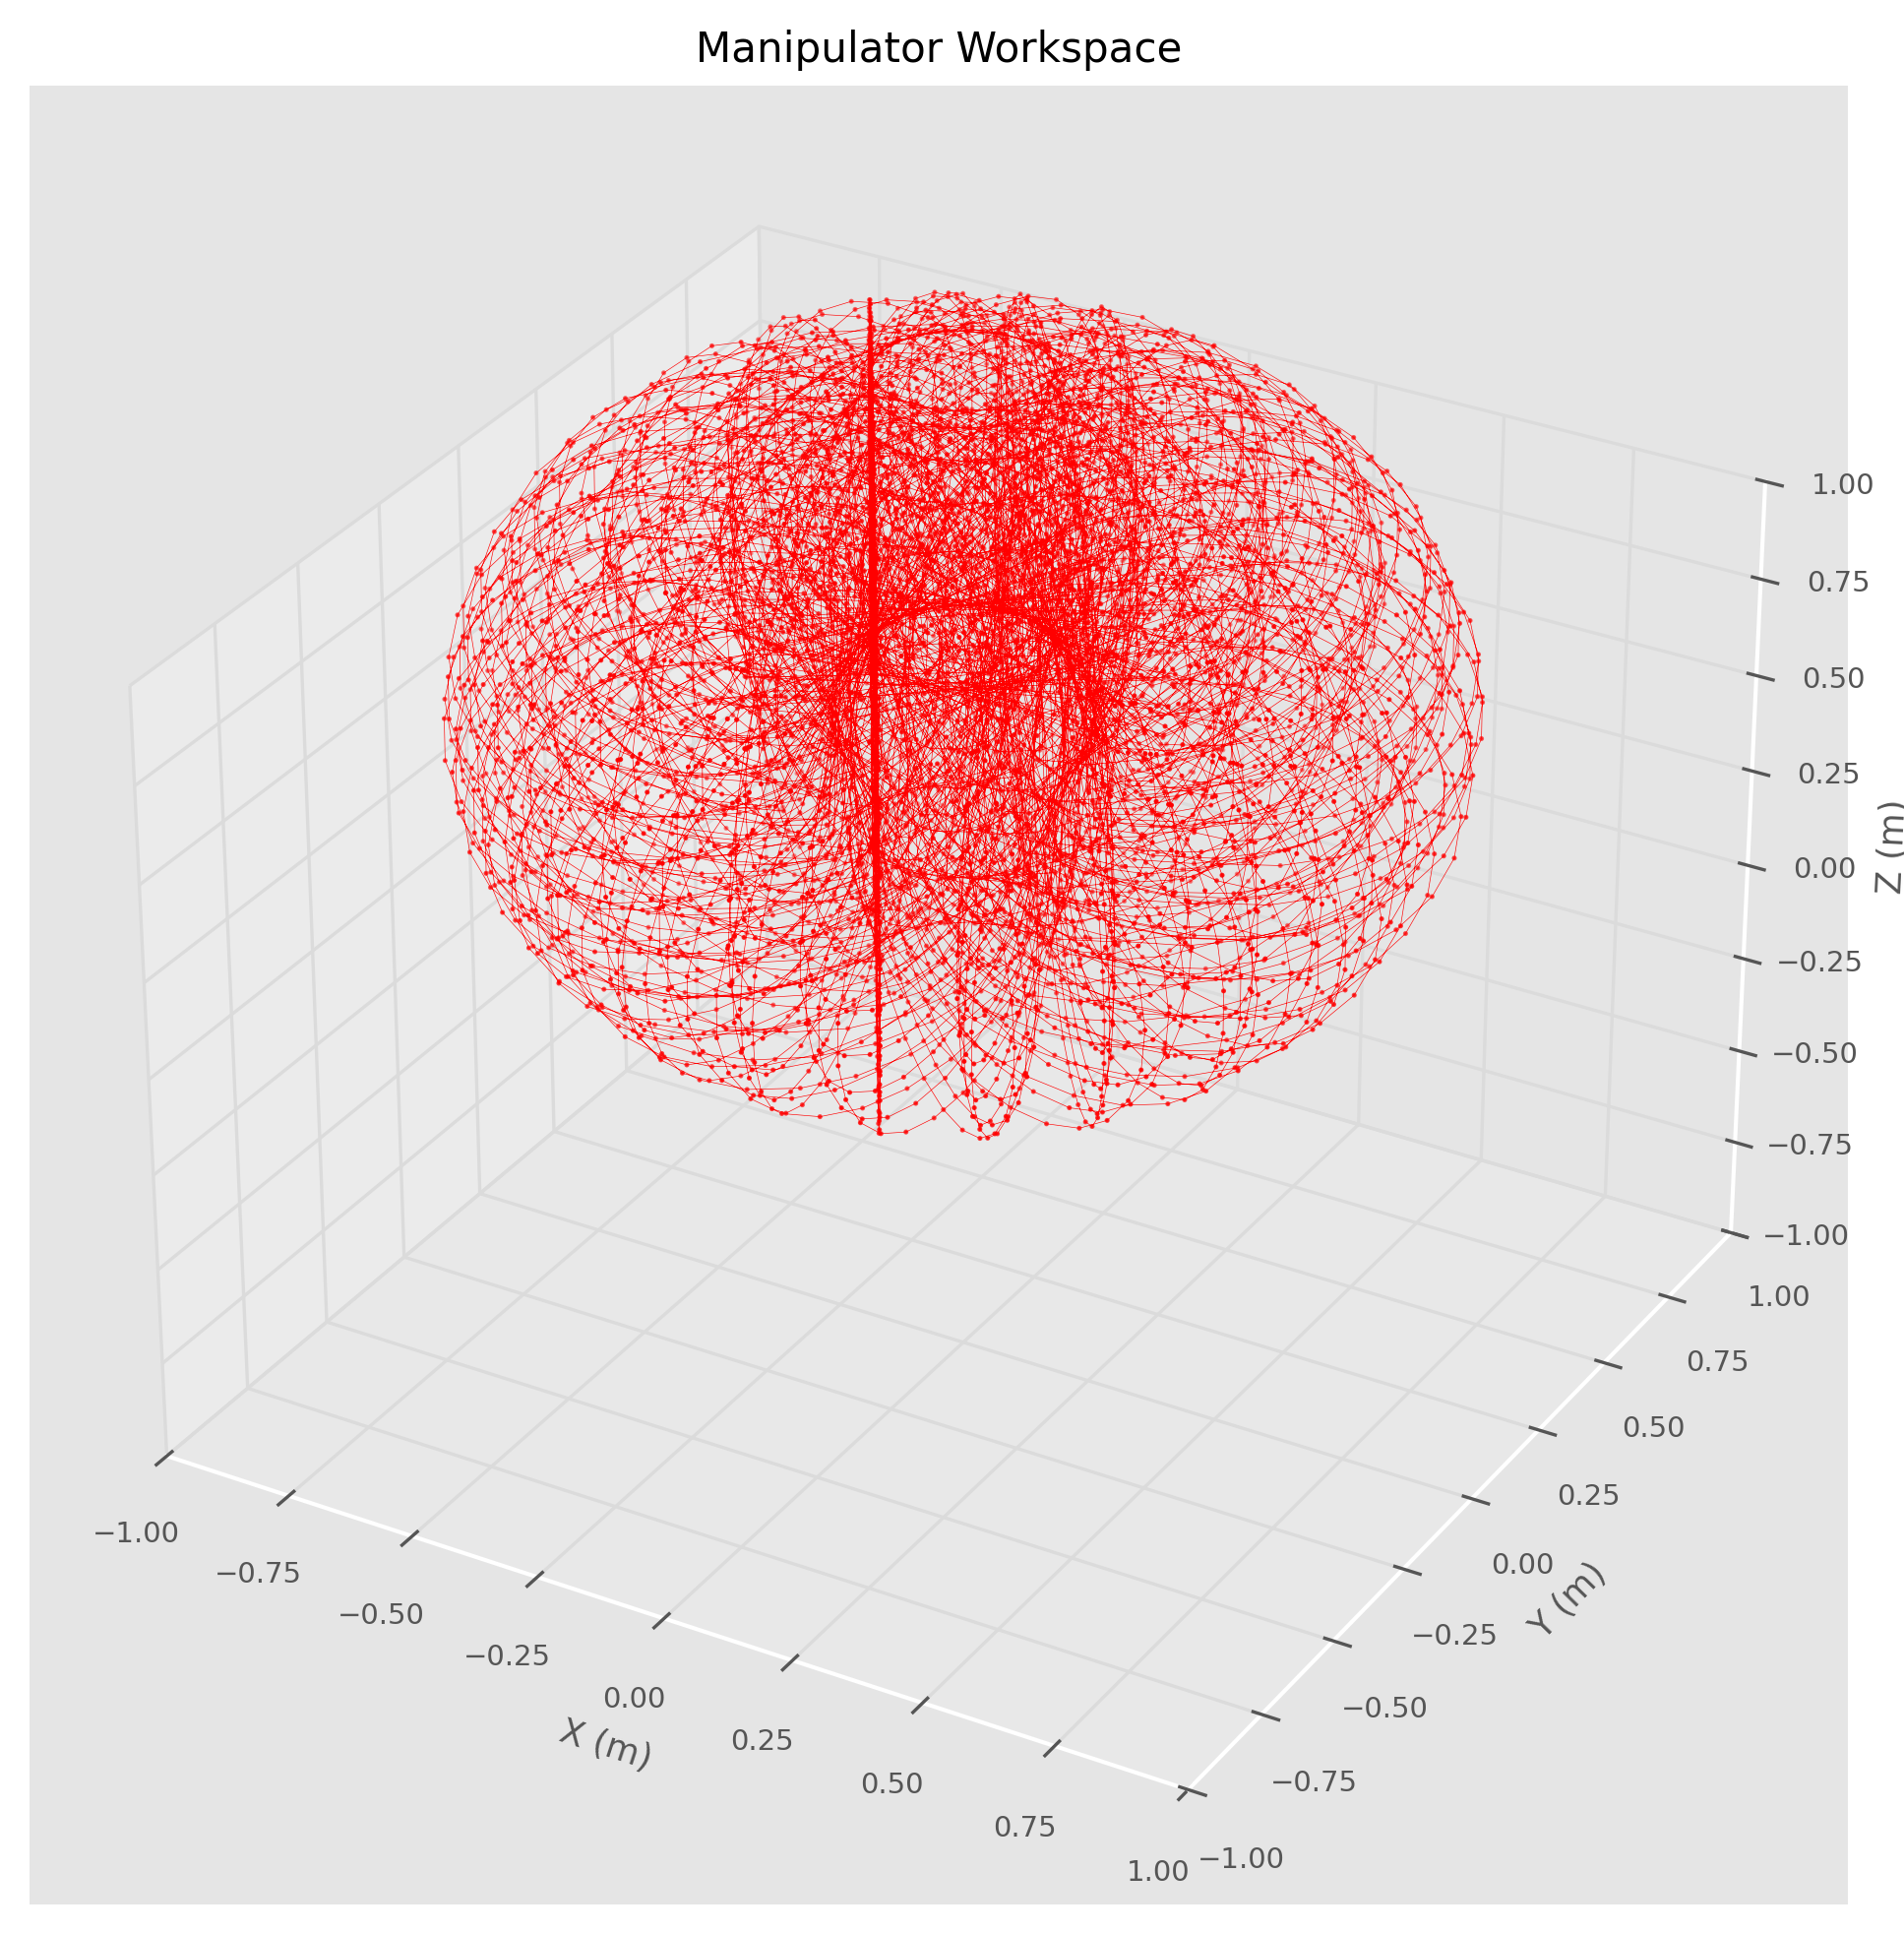

In [58]:
# 4.  Build the manipulator's workspace
print("\nBuilding workspace...")
n = 20  # Reduced number of points for better performance
i = 0
move = [np.linspace(robot.links[i].qlim[0], robot.links[i].qlim[1], n) for i in range(3)]
pose = np.zeros([3, n**3])

for q1 in move[0]:
    for q2 in move[1]:
        for q3 in move[2]:
            Tt = robot.fkine([q1, q2, q3, 0, 0, 0])
            for j in range(3):
                pose[j][i] = Tt.t[j]
            i += 1

# Plot workspace
plt.figure(figsize=(8, 8), dpi=300)
ax = plt.axes(projection="3d")
ax.plot3D(pose[0], pose[1], pose[2], color='red', linewidth=0.15)
ax.scatter3D(pose[0], pose[1], pose[2], s=0.5, color='red')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
plt.title("Manipulator Workspace")
plt.show()


### 7. Выберем конечную точку и проверим её (решим обратную задачу кинематики)


Selected end point: [-0.5, 0.1, 0.2]

Target transformation matrix (T_end):
[[ 1.   0.   0.  -0.5]
 [ 0.   1.   0.   0.1]
 [ 0.   0.   1.   0.2]
 [ 0.   0.   0.   1. ]]

Inverse kinematics solution:
q1: -0.496 rad, q2: -1.704 rad, q3: -2.860 rad
q4: 0.000 rad, q5: -1.719 rad, q6: 0.496 rad


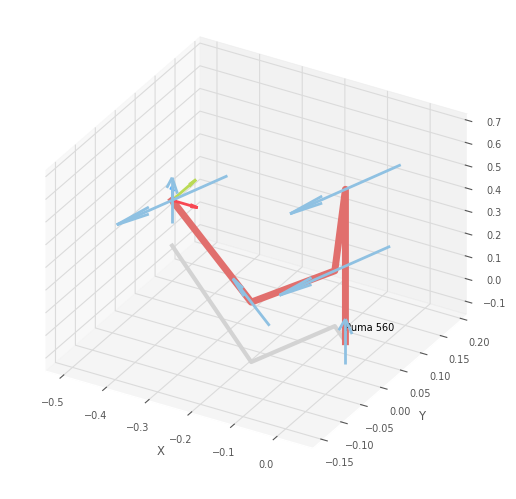

<Figure size 640x480 with 0 Axes>

In [59]:
# 5.Select end point and solve inverse kinematics
point = [-0.5, 0.1, 0.2]
print(f"\nSelected end point: {point}")
T_end = sb.transl(point)
#T_end = SE3.Trans(point) * SE3.Rx(pi/4) * SE3.Ry(pi/6)  # Add orientation
print("\nTarget transformation matrix (T_end):")
print(T_end)

# Solve inverse kinematics
sol = robot.ikine_LM(T_end, q0=q_start)
if not sol.success:
    print("Inverse kinematics failed!")
else:
    #q_end = sol.q
    q_end = robot.ikine_GN(T_end).q
    print("\nInverse kinematics solution:")
    print(f"q1: {q_end[0]:.3f} rad, q2: {q_end[1]:.3f} rad, q3: {q_end[2]:.3f} rad")
    print(f"q4: {q_end[3]:.3f} rad, q5: {q_end[4]:.3f} rad, q6: {q_end[5]:.3f} rad")
    
    # Plot final configuration
    robot.plot(q_end)
    plt.show()


### 8. Спланируем траекторию

Спланируем траекторию методом 'jtraj' для = 100 точек

Спланируем ту же траекторию методом 'mtraj' с функцией 'trapezoidal'

Спланируем ту же траекторию методом 'mtraj' с функцией 'quintic'

In [60]:
# 6. Plan trajectory with three methods
N = 100
t_start = 0
t_stop = 5
t_shag = t_stop/N
time = np.arange(t_start, t_stop, t_shag)

print("\nPlanning trajectories...")
# Method 1: jtraj (quintic polynomial trajectory)
tr_jtraj = rtb.jtraj(q_start, q_end, time)

# Method 2: mtraj with trapezoidal velocity profile
tr_trap = rtb.mtraj(trapezoidal, q_start, q_end, time)

# Method 3: mtraj with quintic polynomial
tr_quin = rtb.mtraj(quintic, q_start, q_end, time)


Planning trajectories...


### 9. Построим графики

Построим графики положений для каждого звена

Построим графики скоростей для каждого звена


Построим графики ускорений для каждого звена

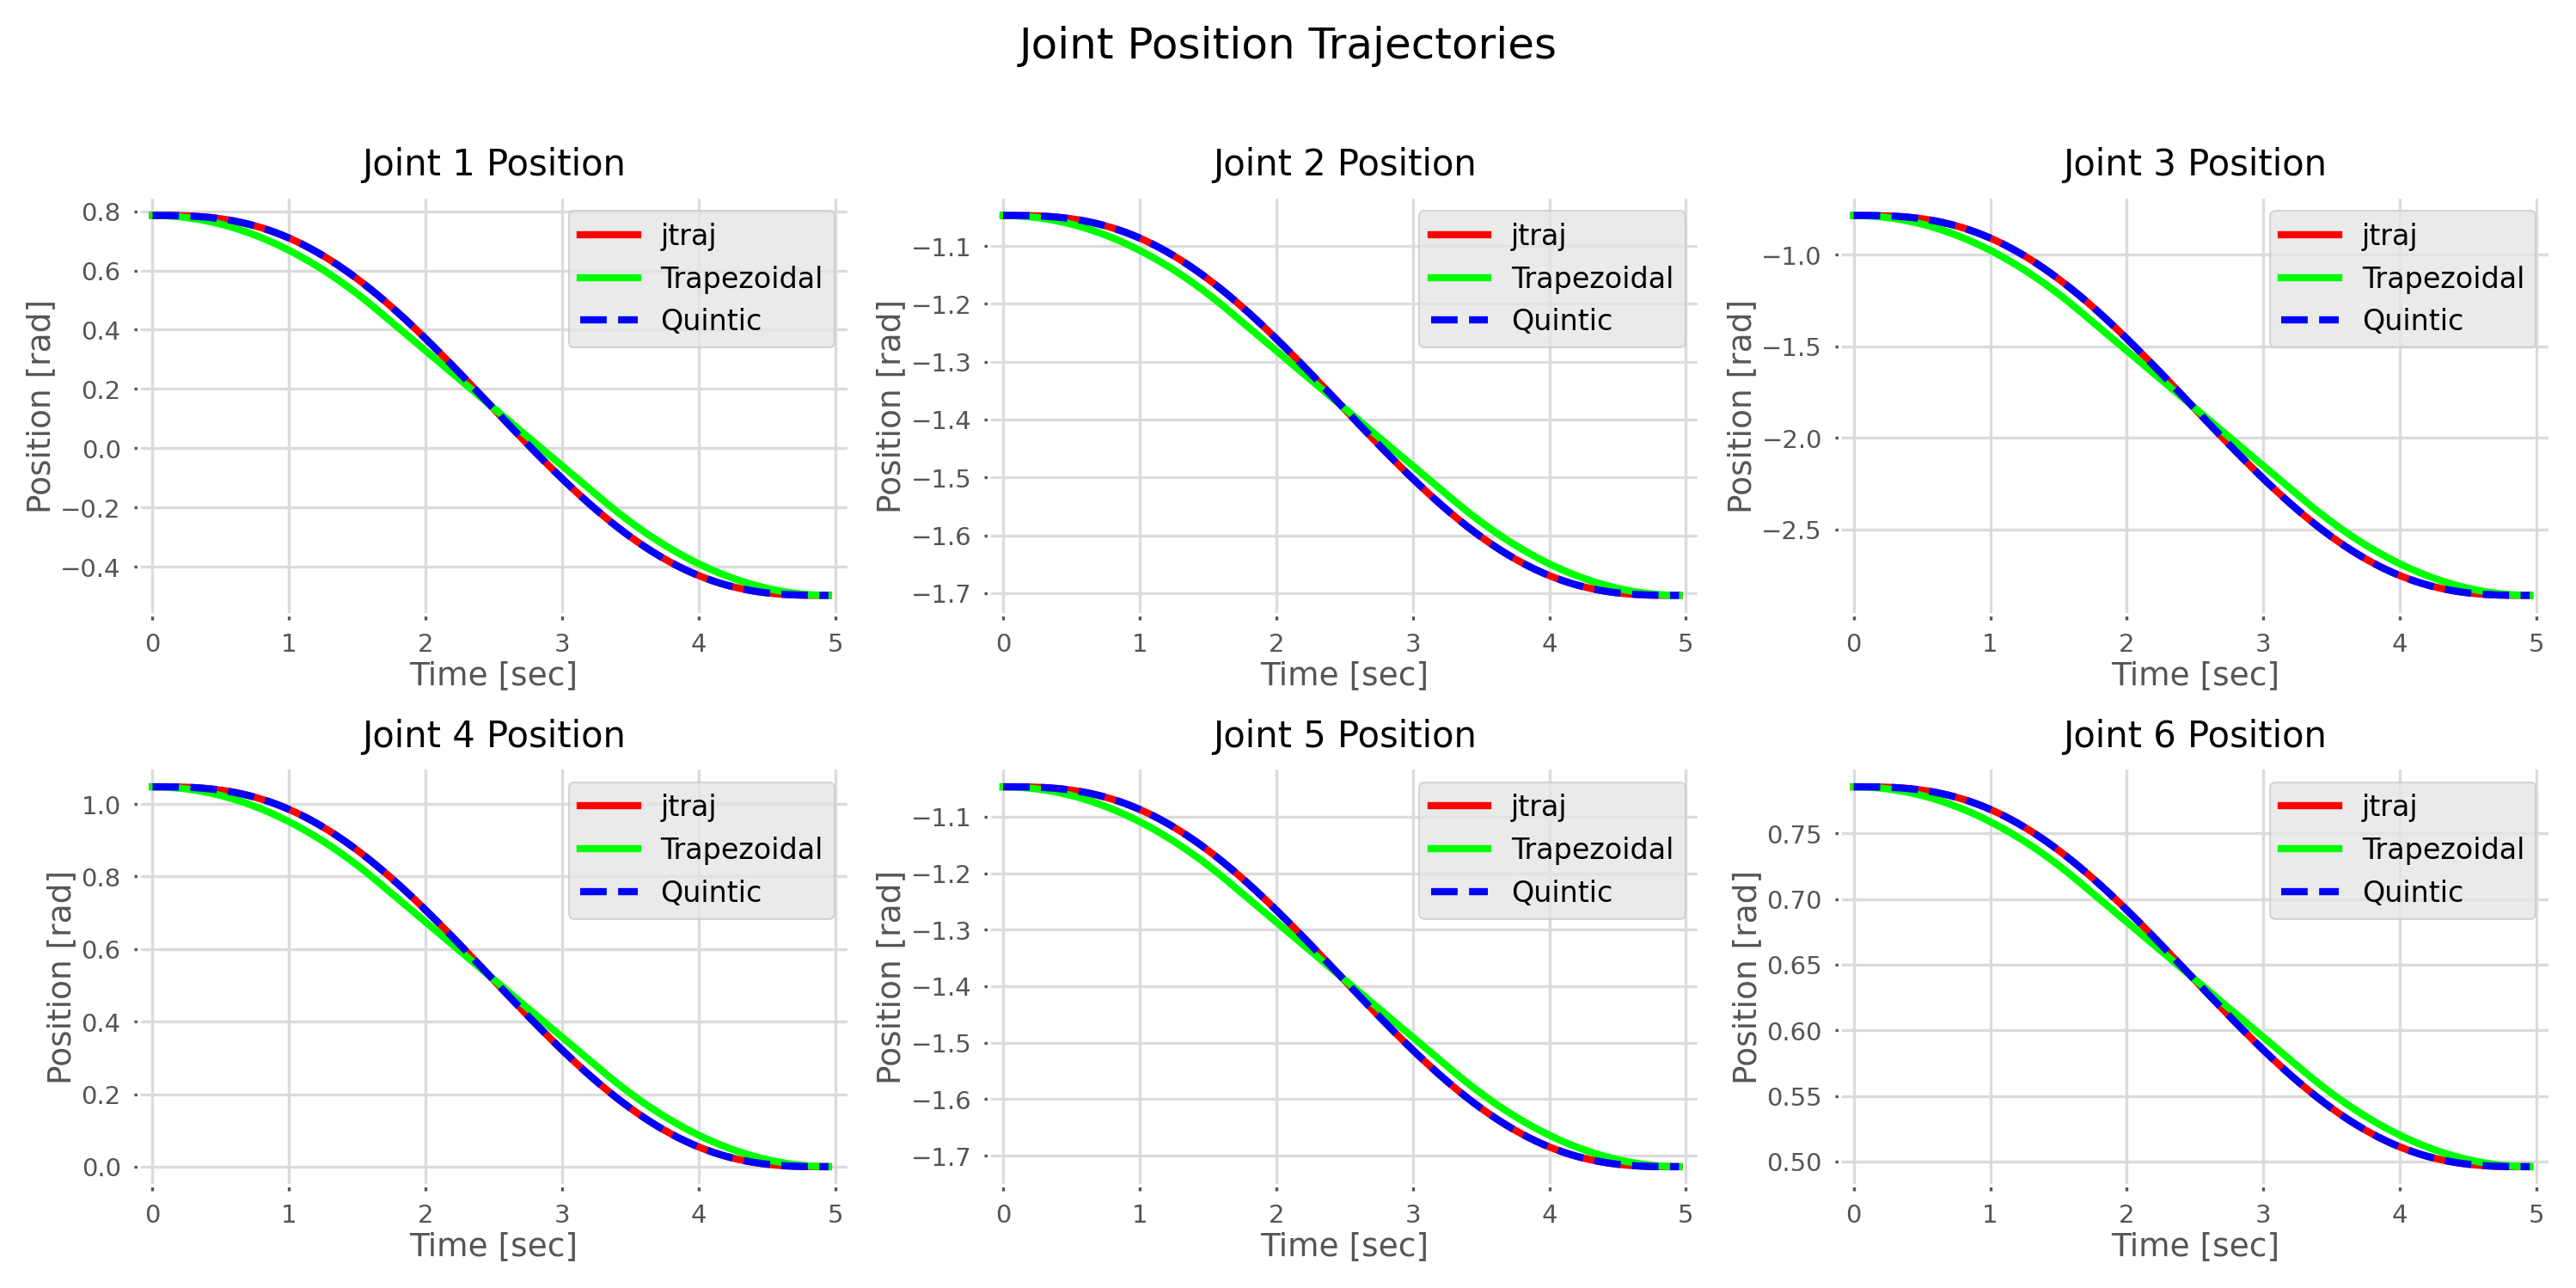

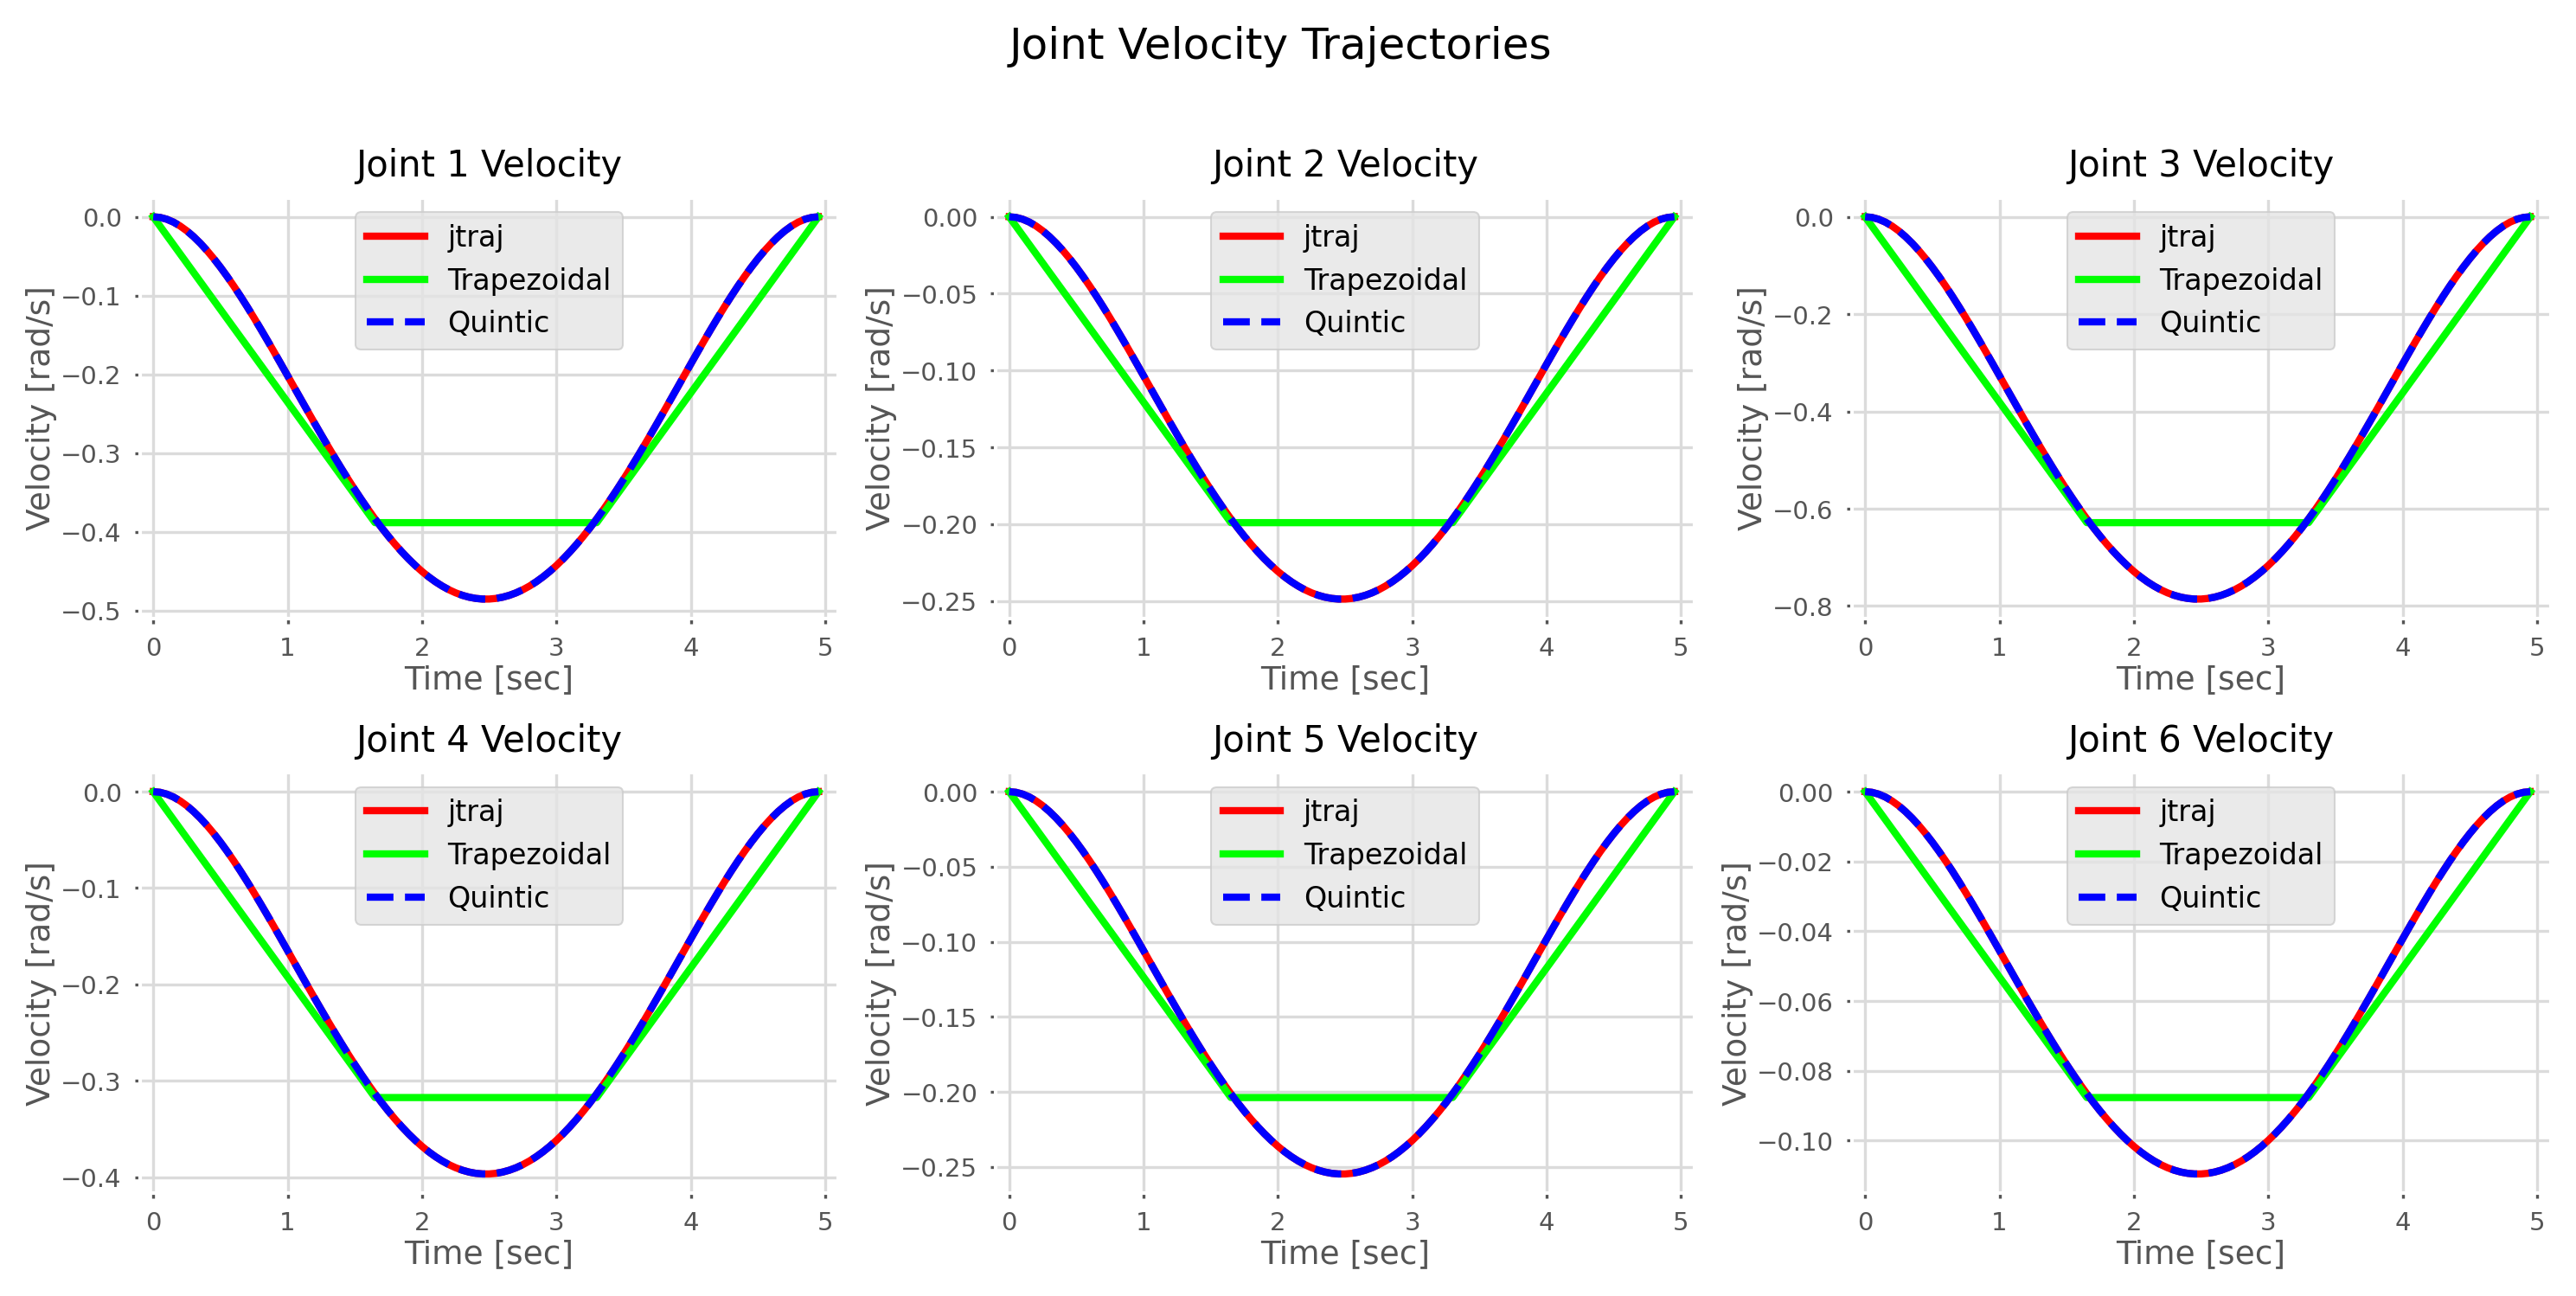

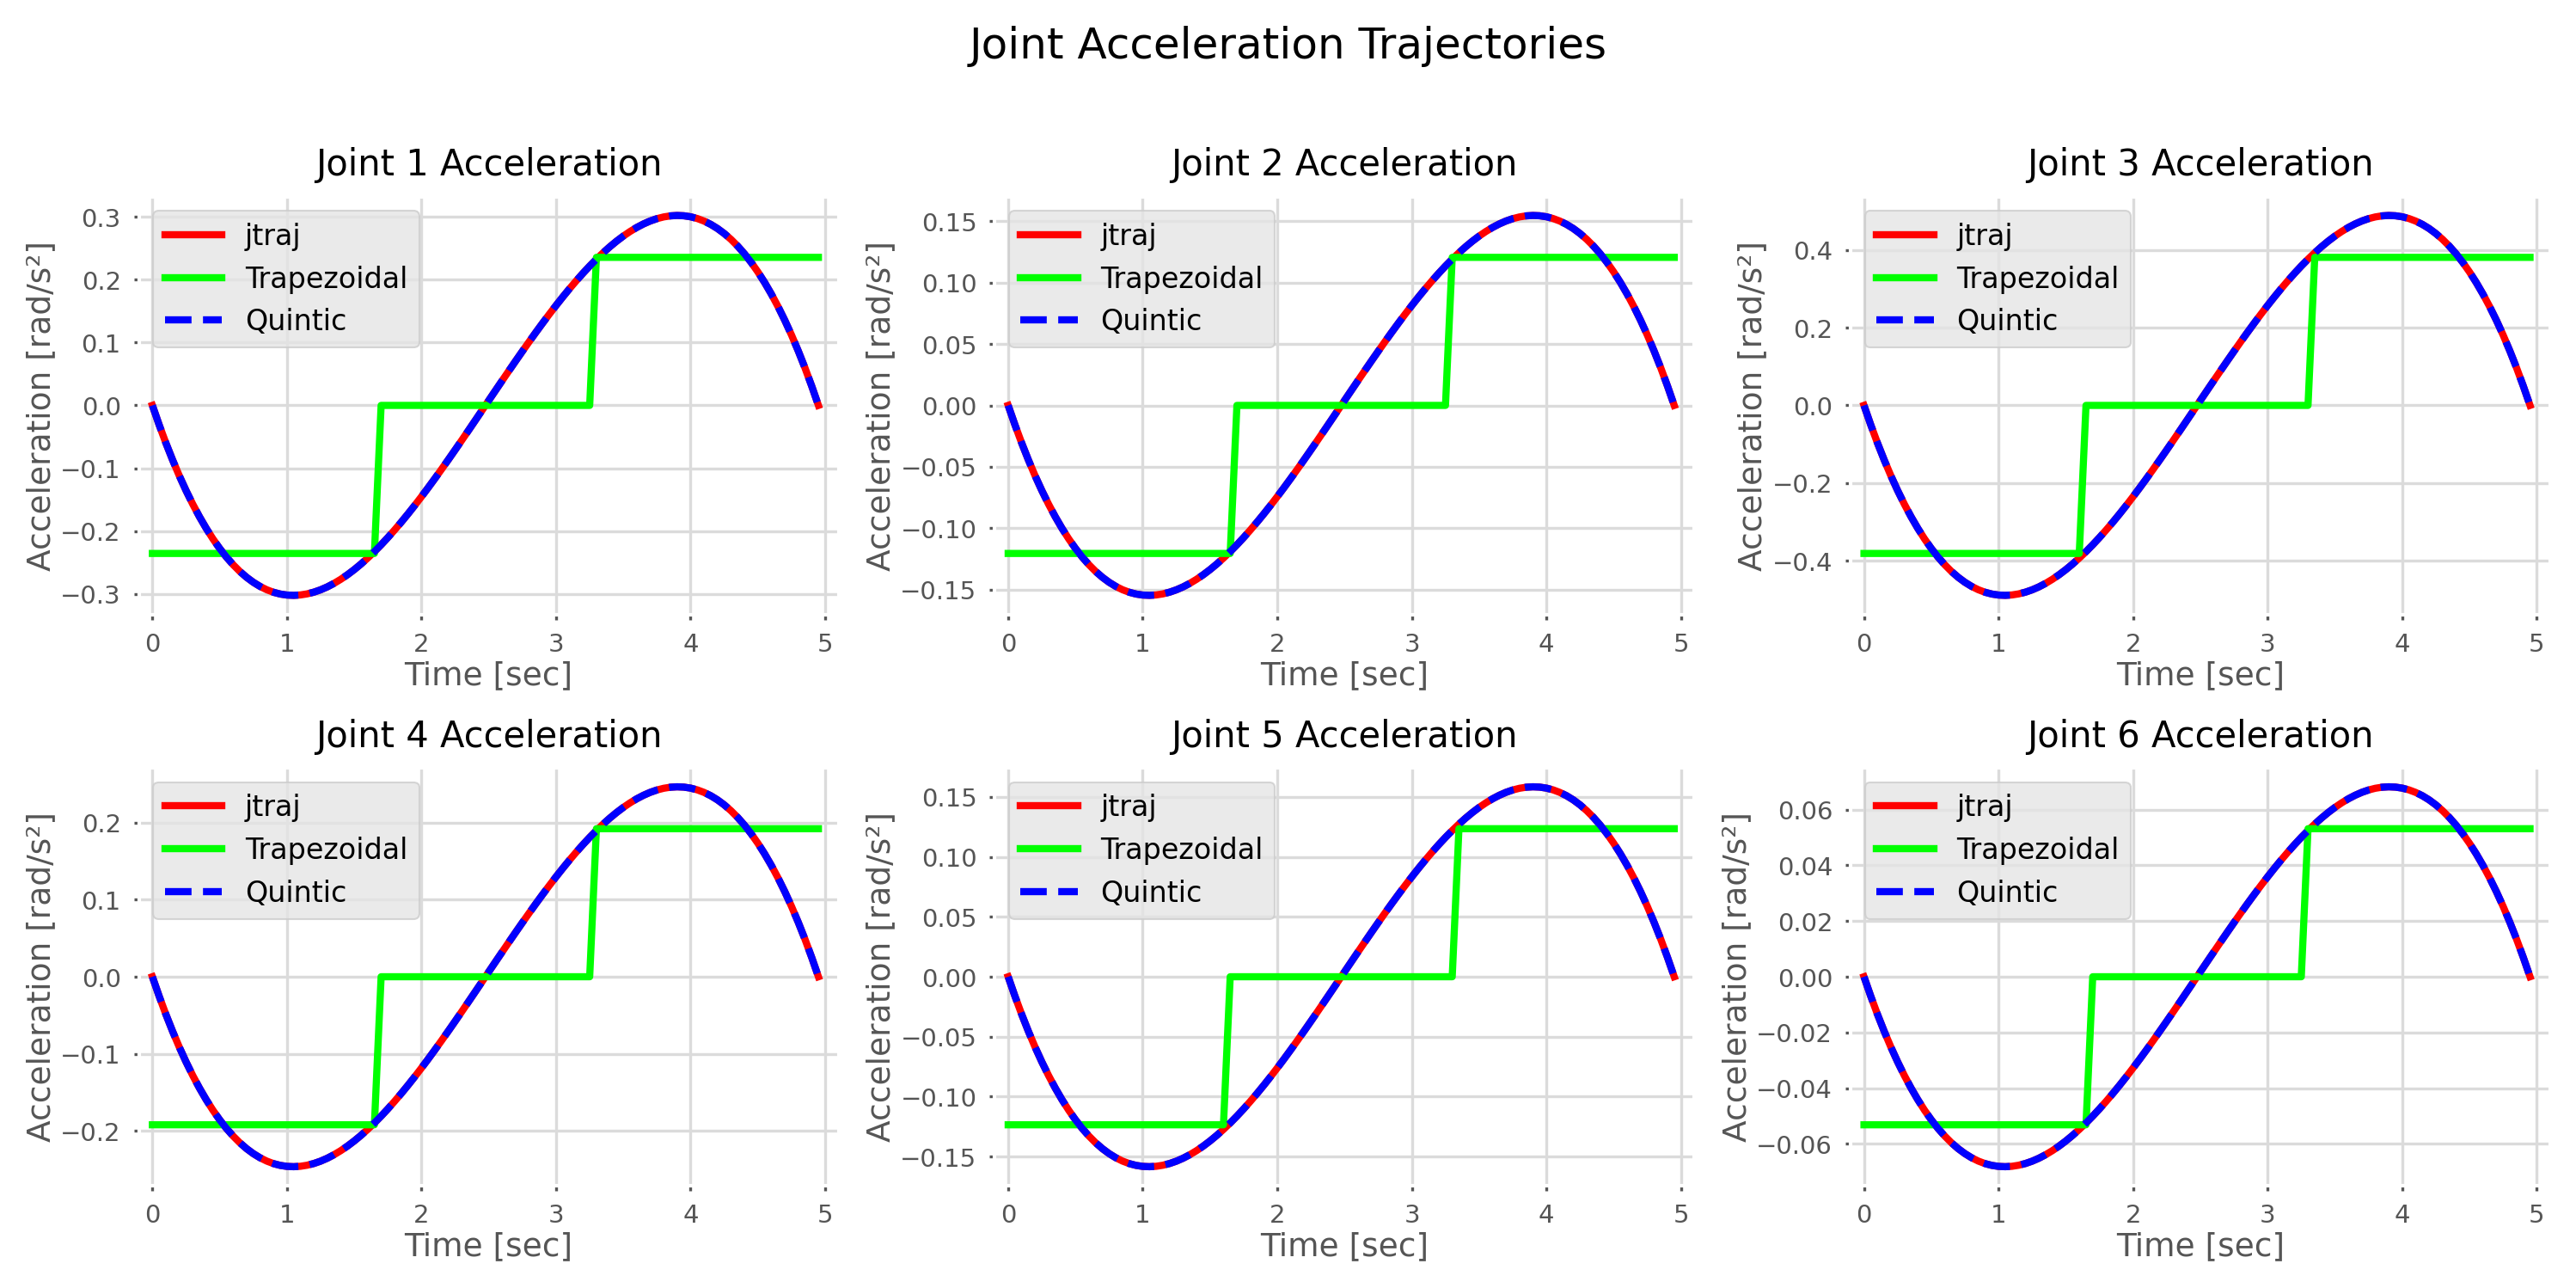

In [61]:
#7. Position plots with English labels
plt.figure(figsize=(10, 5), dpi=300)
for g in range(1, 7):
    plt.subplot(2, 3, g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.25)
    
    # Extract position data
    pos_jtraj = tr_jtraj.q[:, g-1]
    pos_trap = tr_trap.q[:, g-1]
    pos_quin = tr_quin.q[:, g-1]
    
    plt.plot(time, pos_jtraj, linestyle='-', linewidth=2, color=(1, 0, 0), label=r"jtraj")
    plt.plot(time, pos_trap, linestyle='-', linewidth=2, color=(0, 1, 0), label=r"Trapezoidal")
    plt.plot(time, pos_quin, linestyle='--', linewidth=2, color=(0, 0, 1), label=r"Quintic")
    
    plt.title(f"Joint {g} Position", fontsize=10)
    plt.ylabel(r"Position [rad]", fontsize=9)
    plt.xlabel(r"Time [sec]", fontsize=9)
    plt.grid(True)
    plt.legend(fontsize=8)
    
    ax = plt.gca()
    ax.set_facecolor((1, 1, 1))
    ax.set_xlim([t_start-0.1, t_stop+0.1])
    
plt.suptitle('Joint Position Trajectories', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Velocity plots with English labels
plt.figure(figsize=(10, 5), dpi=300)
for g in range(1, 7):
    plt.subplot(2, 3, g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)
    
    # Extract velocity data
    vel_jtraj = tr_jtraj.qd[:, g-1]
    vel_trap = tr_trap.qd[:, g-1]
    vel_quin = tr_quin.qd[:, g-1]
    
    plt.plot(time, vel_jtraj, linestyle='-', linewidth=2, color=(1, 0, 0), label=r"jtraj")
    plt.plot(time, vel_trap, linestyle='-', linewidth=2, color=(0, 1, 0), label=r"Trapezoidal")
    plt.plot(time, vel_quin, linestyle='--', linewidth=2, color=(0, 0, 1), label=r"Quintic")
    
    plt.title(f"Joint {g} Velocity", fontsize=10)
    plt.ylabel(r"Velocity [rad/s]", fontsize=9)
    plt.xlabel(r"Time [sec]", fontsize=9)
    plt.grid(True)
    plt.legend(fontsize=8)
    
    ax = plt.gca()
    ax.set_facecolor((1, 1, 1))
    ax.set_xlim([t_start-0.1, t_stop+0.1])
    
plt.suptitle('Joint Velocity Trajectories', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Acceleration plots with English labels
plt.figure(figsize=(10, 5), dpi=300)
for g in range(1, 7):
    plt.subplot(2, 3, g)
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.25)
    
    # Extract acceleration data
    acc_jtraj = tr_jtraj.qdd[:, g-1]
    acc_trap = tr_trap.qdd[:, g-1]
    acc_quin = tr_quin.qdd[:, g-1]
    
    plt.plot(time, acc_jtraj, linestyle='-', linewidth=2, color=(1, 0, 0), label=r"jtraj")
    plt.plot(time, acc_trap, linestyle='-', linewidth=2, color=(0, 1, 0), label=r"Trapezoidal")
    plt.plot(time, acc_quin, linestyle='--', linewidth=2, color=(0, 0, 1), label=r"Quintic")
    
    plt.title(f"Joint {g} Acceleration", fontsize=10)
    plt.ylabel(r"Acceleration [rad/s²]", fontsize=9)
    plt.xlabel(r"Time [sec]", fontsize=9)
    plt.grid(True)
    plt.legend(fontsize=8)
    
    ax = plt.gca()
    ax.set_facecolor((1, 1, 1))
    ax.set_xlim([t_start-0.1, t_stop+0.1])
    
plt.suptitle('Joint Acceleration Trajectories', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Animating jtraj trajectory...


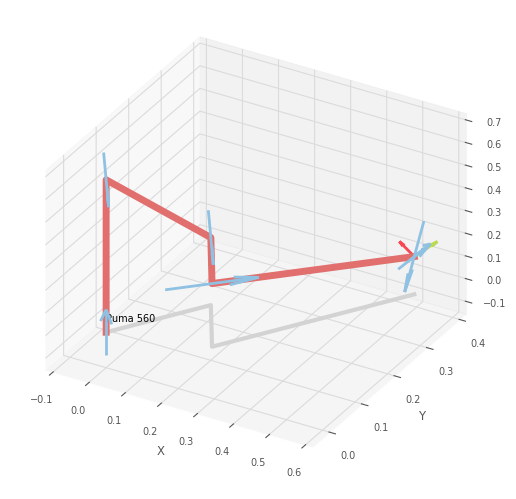

<Figure size 640x480 with 0 Axes>

Animating trapezoidal trajectory...


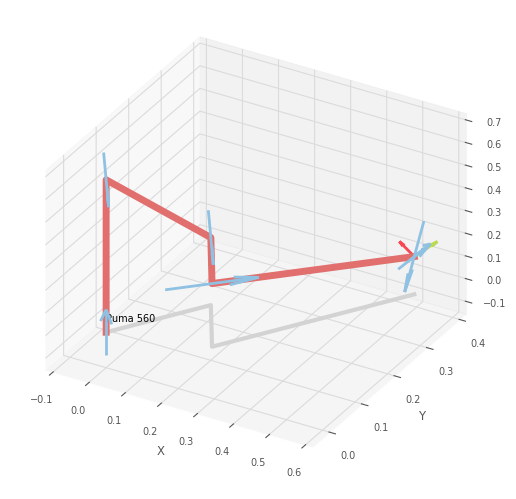

<Figure size 640x480 with 0 Axes>

Animating quintic trajectory...


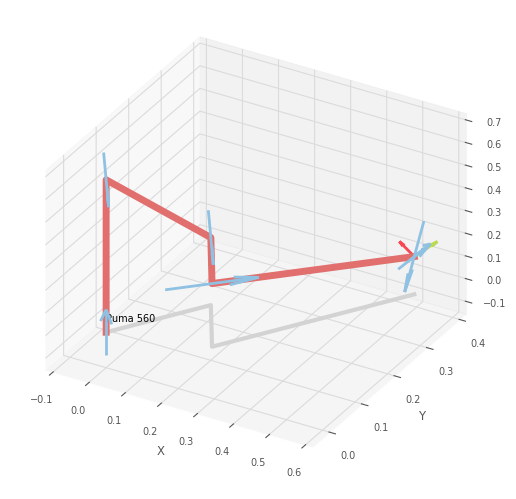

<Figure size 640x480 with 0 Axes>

In [62]:
# 8. Animate the trajectories
print("\nAnimating jtraj trajectory...")
robot.plot(tr_jtraj.q, dt=0.05)
plt.show()

print("Animating trapezoidal trajectory...")
robot.plot(tr_trap.q, dt=0.05)
plt.show()

print("Animating quintic trajectory...")
robot.plot(tr_quin.q, dt=0.05)
plt.show()


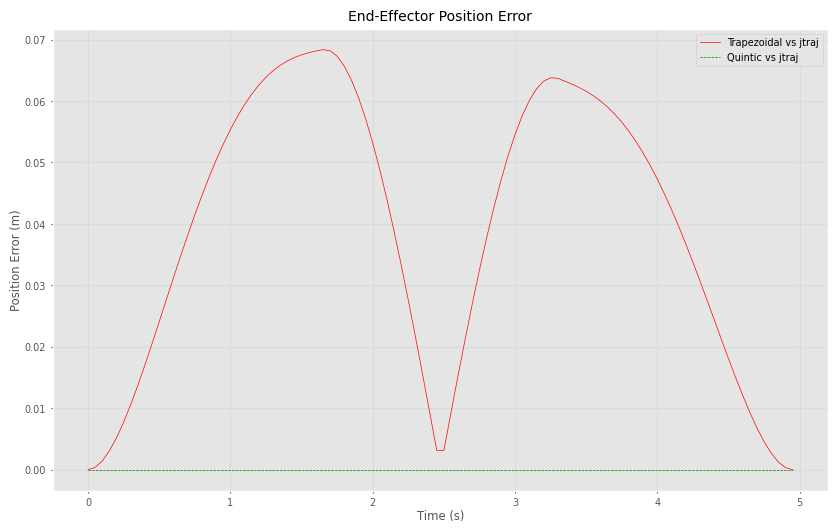


Trajectory Analysis:
Max trapezoidal error: 0.068353 m
Max quintic error: 0.000000 m
RMS trapezoidal error: 0.045259 m
RMS quintic error: 0.000000 m


In [63]:
# 9. Calculate and display trajectory errors
def calculate_position_error(traj1, traj2):
    return np.sqrt(np.sum((traj1 - traj2)**2, axis=1))

# Calculate end-effector positions for each trajectory
ee_jtraj = np.array([robot.fkine(q).t for q in tr_jtraj.q])
ee_trap = np.array([robot.fkine(q).t for q in tr_trap.q])
ee_quin = np.array([robot.fkine(q).t for q in tr_quin.q])

# Calculate errors relative to jtraj (considered as reference)
err_trap = calculate_position_error(ee_jtraj, ee_trap)
err_quin = calculate_position_error(ee_jtraj, ee_quin)

# Plot position errors
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(time, err_trap, 'r-', label='Trapezoidal vs jtraj')
plt.plot(time, err_quin, 'g--', label='Quintic vs jtraj')
plt.title('End-Effector Position Error')
plt.ylabel('Position Error (m)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.legend()
plt.show()

print("\nTrajectory Analysis:")
print(f"Max trapezoidal error: {np.max(err_trap):.6f} m")
print(f"Max quintic error: {np.max(err_quin):.6f} m")
print(f"RMS trapezoidal error: {np.sqrt(np.mean(err_trap**2)):.6f} m")
print(f"RMS quintic error: {np.sqrt(np.mean(err_quin**2)):.6f} m")

In [64]:
# 10. Conclusions
print("\nConclusions:")
print("1. All three trajectory planning methods successfully moved the robot from start to end position.")
print("2. The jtraj method (5th-order polynomial) produces smooth motion with continuous acceleration.")
print("3. The trapezoidal method has constant acceleration phases but discontinuous jerk.")
print("4. The quintic method produces the smoothest motion but requires higher torque at joints.")
print("5. Workspace visualization shows the reachable area considering joint limits.")
print("6. Position errors between methods are minimal, confirming consistency in inverse kinematics solutions.")
print("7. The choice of trajectory depends on application requirements: smoothness vs. computational efficiency.")


Conclusions:
1. All three trajectory planning methods successfully moved the robot from start to end position.
2. The jtraj method (5th-order polynomial) produces smooth motion with continuous acceleration.
3. The trapezoidal method has constant acceleration phases but discontinuous jerk.
4. The quintic method produces the smoothest motion but requires higher torque at joints.
5. Workspace visualization shows the reachable area considering joint limits.
6. Position errors between methods are minimal, confirming consistency in inverse kinematics solutions.
7. The choice of trajectory depends on application requirements: smoothness vs. computational efficiency.
